# Build a Multi-Omics Container for GCN Training
The goal of this little notebook is to create one HDF5 container that contains a feature matrix consisting of our multi-omics data:
* Mutation Frequencies
* Gene Expression
* Methylation
We then can train our network using the iref PPI and these different data sources.

In [1]:
import h5py, sys, os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn

sys.path.append(os.path.abspath('../../GCN'))
import gcnPreprocessing
plt.rc('font', family='Times New Roman')
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
# PARAMETERS
use_quantile_norm = False # quantile or MinMax normalization
use_ncg_labels = True # use the new labels or the old ones

## Load the Data from three containers

In [7]:
# mutation frequencies
with h5py.File('../../data/pancancer/mutfreq_iref_unbalanced_syn.h5', 'r') as f:
    network = f['network'][:]
    mutfreq_features = f['features_mean'][:]
    #features_mean = f['features_mean'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

# methylation levels
with h5py.File('../../data/pancancer/iref_methylation_450k1000bpprom_all.h5', 'r') as f:
    meth_features = f['features'][:]
    node_names_meth = f['gene_names'][:]

# gene expression
with h5py.File('../../data/pancancer/iref_tcga_expression_filter100.h5', 'r') as f:
    ge_features = f['features'][:]
    node_names_ge = f['gene_names'][:]

In [8]:
# verify that the genes are the same and that they are in the same order
print ((node_names_ge == node_names_meth).all())
print ((node_names == node_names_meth).all())
print ((node_names == node_names_ge).all())

True
True
True


## Join Multi-Omics to form one feature matrix

In [9]:
if use_quantile_norm:
    scaler = preprocessing.QuantileTransformer()
else:
    scaler = preprocessing.MinMaxScaler()
ge_norm = scaler.fit_transform(ge_features)
mutfreq_norm = scaler.fit_transform(mutfreq_features)
meth_norm = scaler.fit_transform(meth_features)

multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
multi_omics_features_raw = np.concatenate((mutfreq_features, meth_features, ge_features), axis=1)

In [5]:
#np.save('../../data/pancancer/multiomics_features_raw.npy', multi_omics_features_raw)

### Plot Distribution of Features

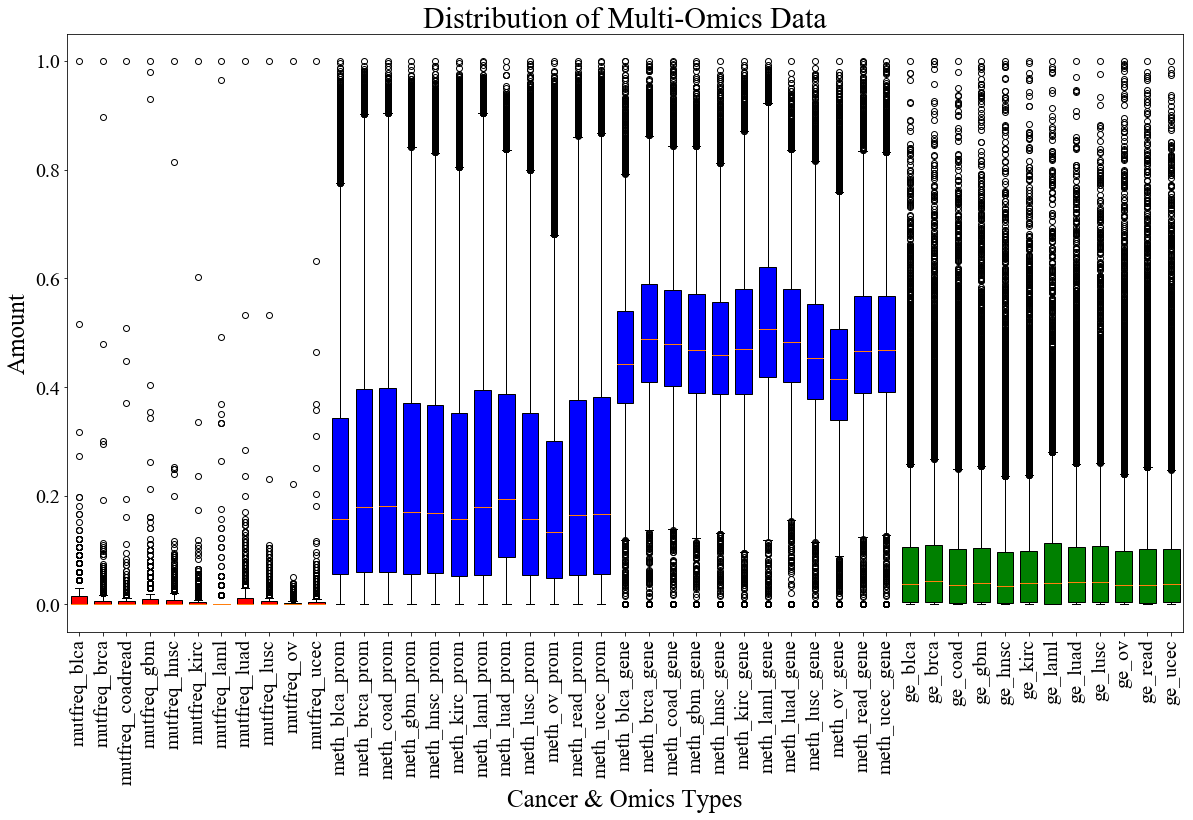

In [10]:
# plot distribution of features
fig = plt.figure(figsize=(20, 11))

# mutation frequencies
cancer_names = ['blca', 'brca', 'coadread', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'ucec']
feat_names_mut = ['mutfreq_'+i for i in cancer_names]

# gene expression
cnames_full = ['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc', 'laml', 'luad', 'lusc', 'ov', 'read', 'ucec']
feat_names_ge = ['ge_'+i for i in cnames_full]

# methylation
feat_names_meth = ['meth_{}_prom'.format(i) for i in cnames_full] + ['meth_{}_gene'.format(i) for i in cnames_full]
feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge

# plot
x = plt.boxplot(multi_omics_features, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, multi_omics_features.shape[1]+1), feat_names_all, rotation='vertical', fontsize=20)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*11 + ['blue']*24 + ['green']*12
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-0.05, 1.5])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.title('Distribution of Multi-Omics Data', fontsize=30)
if use_quantile_norm:
    fig.savefig('multi_omics_feature_distribution_quantiled.png', dpi=300)
else:
    fig.savefig('multi_omics_feature_distribution_normminmax.png', dpi=300)

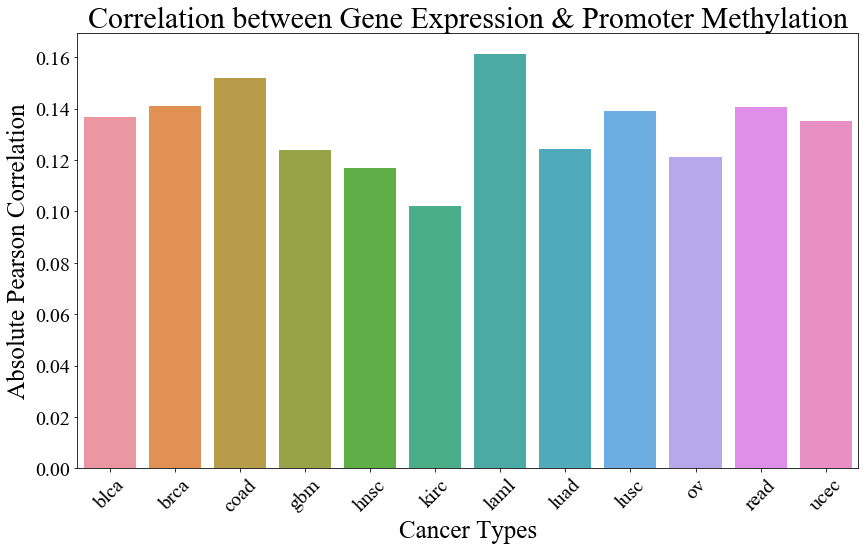

In [11]:
import scipy
methgecorr = []
for i in range(12):
    corr = scipy.stats.pearsonr(meth_features[:, i], ge_features[:, i])
    #print ("Correlation for {} between promoter methylation and gene expression: {}".format(cnames_full[i], corr))
    methgecorr.append(abs(corr[0]))

fig = plt.figure(figsize=(14, 8))
ax = seaborn.barplot(x=list(range(12)), y=methgecorr)
_ = plt.xlabel('Cancer Types', fontsize=25)
_ = plt.ylabel('Absolute Pearson Correlation', fontsize=25)
_ = plt.xticks(range(12), cnames_full, rotation=45, fontsize=20)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)
plt.title('Correlation between Gene Expression & Promoter Methylation', fontsize=30)

## Get Labels

In [12]:
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes.set_index('ID', inplace=True)

known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

In [13]:
# get rid of the vogelstein cancer genes
not_positives = nodes[~nodes.Name.isin(known_cancer_genes)]
print ("{} genes are in network but not in Vogelstein list (oncogenes)".format(not_positives.shape[0]))

# get rid of the OMIM disease genes
omim_genes = pd.read_csv('../../data/pancancer/OMIM/genemap2.txt', sep='\t', comment='#', header=None)
omim_genes.columns = ['Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Cyto Location',
                      'Computed Cyto Location', 'Mim Number', 'Gene Symbol', 'Gene Name',
                      'Approved Symbol', 'Entrez Gene ID', 'Ensembl Gene ID', 'Comments',
                      'Phenotypes', 'Mouse Gene Symbol/ID']
omim_gene_names = []
for idx, row in omim_genes.iterrows():
    gene_names = row['Gene Symbol'].strip().split(',')
    omim_gene_names += gene_names
omim_gene_names = list(set(omim_gene_names))
not_omim_not_pos = not_positives[~not_positives.Name.isin(omim_gene_names)]
print ("{} genes are in network but not in oncogenes and not in OMIM".format(not_omim_not_pos.shape[0]))

# get rid of genes that are not in COSMIC
cosmic_gene_scores = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv', header=0)
not_omim_cosmic_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes in network but not in oncogenes, OMIM and COSMIC cancer gene census.".format(not_omim_cosmic_pos.shape[0]))

# get rid of genes that are not candidate cancer genes
negatives = not_omim_cosmic_pos[~not_omim_cosmic_pos.Name.isin(candidate_cancer_genes)]
print ("{} negatives collected".format(negatives.shape[0]))

11489 genes are in network but not in Vogelstein list (oncogenes)
2262 genes are in network but not in oncogenes and not in OMIM
2258 genes in network but not in oncogenes, OMIM and COSMIC cancer gene census.
2140 negatives collected


## Do Training and Test Split

In [14]:
if use_ncg_labels:
    y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
    mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)
else:
    y = np.logical_or(y_train, y_test)
    mask = np.logical_or(train_mask, test_mask)

In [15]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.shape, train_mask.shape, y_test.shape, test_mask.shape, y_val.shape, val_mask.shape

((12129, 1), (12129,), (12129, 1), (12129,), (12129, 1), (12129,))

## Write back everything to container

In [16]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.close()

    print ("Container written to {}".format(fname))

In [17]:
multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
fname = '../../data/pancancer/iref_multiomics_{}_methwithgb_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                                                     'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network, multi_omics_features, node_names, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_all)

Container written to ../../data/pancancer/iref_multiomics_norm_methwithgb_ncglabels.h5


In [18]:
multi_omics_features_nogbmeth = np.concatenate((mutfreq_norm, meth_norm[:, :12], ge_norm), axis=1)
fname = '../../data/pancancer/iref_multiomics_{}_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                                                     'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network, multi_omics_features_nogbmeth, node_names, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask,
                     feat_names_mut + feat_names_meth[:12] + feat_names_ge)

Container written to ../../data/pancancer/iref_multiomics_norm_ncglabels.h5


## Compute Containers for combinations of two omics data

In [19]:
meth_ge_features = np.concatenate((meth_norm[:, :12], ge_norm), axis=1)
fname = '../../data/pancancer/iref_methge_{}_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                                                     'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network,meth_ge_features, node_names, y_train, y_val, y_test,
                     train_mask, val_mask, test_mask, feat_names_meth [:12] + feat_names_ge)

Container written to ../../data/pancancer/iref_methge_norm_ncglabels.h5


In [20]:
meth_mutfreq_features = np.concatenate((meth_norm[:, :12], mutfreq_norm), axis=1)
fname = '../../data/pancancer/iref_methmutfreq_{}_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                                                     'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network, meth_mutfreq_features, node_names, y_train, y_val,
                     y_test, train_mask, val_mask, test_mask, feat_names_meth[:12] + feat_names_mut)

Container written to ../../data/pancancer/iref_methmutfreq_norm_ncglabels.h5


In [21]:
mutfreq_ge_features = np.concatenate((mutfreq_norm, ge_norm), axis=1)
fname = '../../data/pancancer/iref_mutfreqge_{}_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                                                     'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network,
                     mutfreq_ge_features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask,
                     feat_names_mut + feat_names_ge)

Container written to ../../data/pancancer/iref_mutfreqge_norm_ncglabels.h5


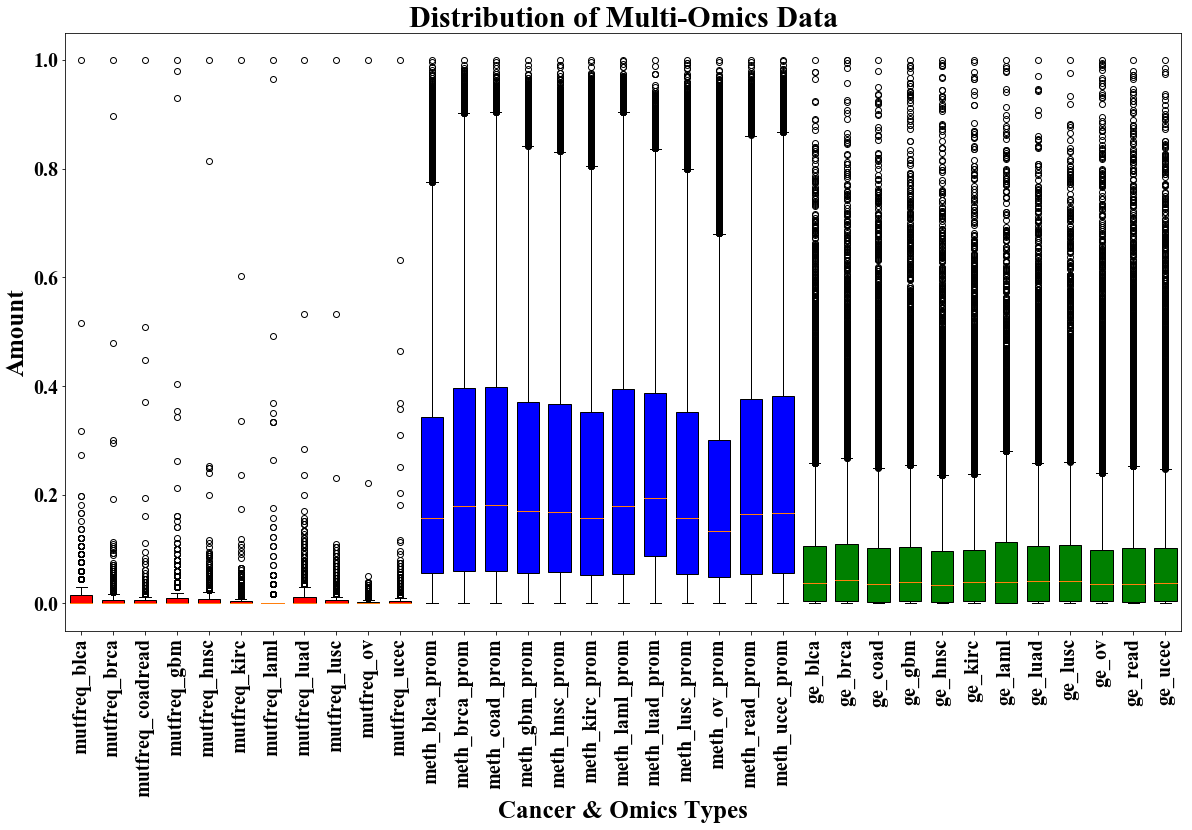

In [38]:
with h5py.File('../../data/pancancer/iref_multiomics_norm_tcgage_methpromonly1000bp.h5', 'r') as f:
    features = f['features'][:]
    f_names = f['feature_names'][:]

# plot distribution of features
fig = plt.figure(figsize=(20, 11))

# plot
x = plt.boxplot(features, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, features.shape[1]+1), f_names, rotation='vertical', fontsize=20)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*11 + ['blue']*12 + ['green']*12
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-0.05, 1.5])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Amount', fontsize=25)
plt.title('Distribution of Multi-Omics Data', fontsize=30)

In [39]:
with h5py.File('../../data/pancancer/iref_multiomics_norm_tcgage_methpromonly1000bp.h5', 'r') as f:
    features = f['features'][:]
    f_names = f['feature_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    y_val = f['y_val'][:]
    train_mask = f['mask_train'][:]
    val_mask = f['mask_val'][:]
    test_mask = f['mask_test'][:]


In [40]:
y = np.logical_or(np.logical_or(y_train, y_val), y_test)
mask = np.logical_or(np.logical_or(train_mask, val_mask), test_mask)

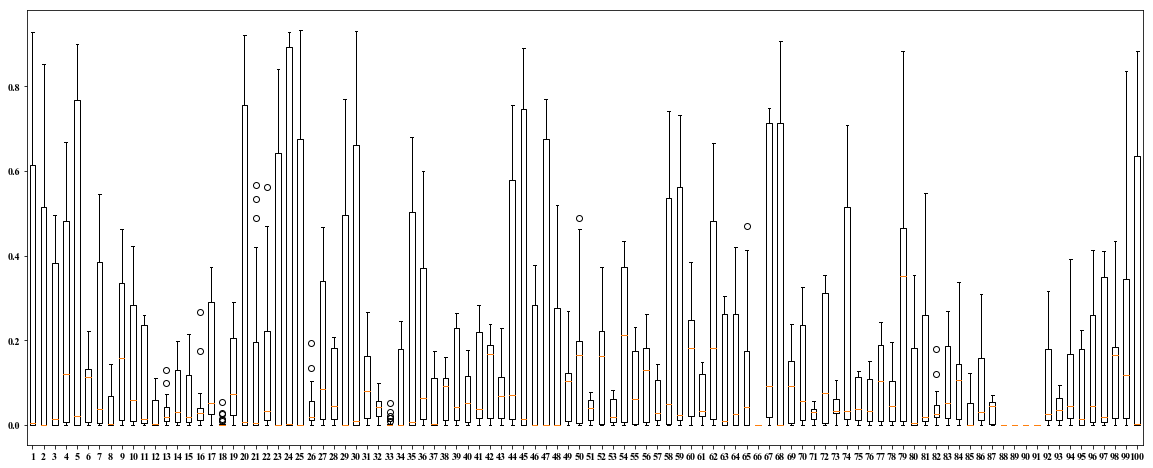

In [41]:
fig = plt.figure(figsize=(20, 8))
_ = plt.boxplot(features[:100].T)